In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import cv2 # type: ignore
import numpy as np
from feat import Detector # type: ignore
import glob
import os
import torch
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [37]:
# Checking the installed PyTorch version and CUDA version
pytorch_version = torch.__version__
cuda_version = torch.version.cuda

pytorch_version, cuda_version

('2.1.1+cu121', '12.1')

In [39]:
# Initialize the detector

detector = Detector(
    face_model="retinaface",
    landmark_model="mobilefacenet",
    au_model='xgb',
    emotion_model="resmasknet",
    facepose_model="img2pose",
    device="cuda",
)

In [40]:
# Initialize the DataFrame to store AU data
aus_data = pd.DataFrame()

# Define the path to the dataset directory
dataset_path = "../Desktop/kaggle_testset/"

# Loop through each emotion subfolder in the dataset directory
for emotion_folder in os.listdir(dataset_path):
    emotion_path = os.path.join(dataset_path, emotion_folder)

    # Check if it's a directory
    if os.path.isdir(emotion_path):
        # Process each image in the subfolder
        for filename in glob.glob(os.path.join(emotion_path, "*.jpg")):
            img = cv2.imread(filename)
            detection = detector.detect_image(filename)

            # Extract AU data
            aus = detection.aus
            au_data = pd.DataFrame(aus)

            # Add emotion label from folder name
            au_data['emotion'] = emotion_folder

            # Rearrange columns to have 'emotion' first
            cols = ['emotion'] + [col for col in au_data.columns if col != 'emotion']
            au_data = au_data[cols]

            # Append to the main DataFrame
            aus_data = pd.concat([aus_data, au_data], ignore_index=True)

# Save the AU data to a CSV file
aus_data.to_csv("aus_kaggle_set.csv", index=False)

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]
C:\Users\lasse\AppData\Local\Temp\ipykernel_15792\1527144478.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aus_data = pd.concat([aus_data, au_data], ignore_index=True)
100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
C:\Users\lasse\AppData\Local\Temp\ipykernel_15792\1527144478.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aus_data = pd.concat([aus_data, au_data], ignore_index=True)
100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
C:\Users\las

In [35]:
# Load the dataset
data = pd.read_csv('aus_diffusion_fer.csv')
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

<Axes: title={'center': 'Emotion Distribution'}, xlabel='Emotion', ylabel='Frequency'>

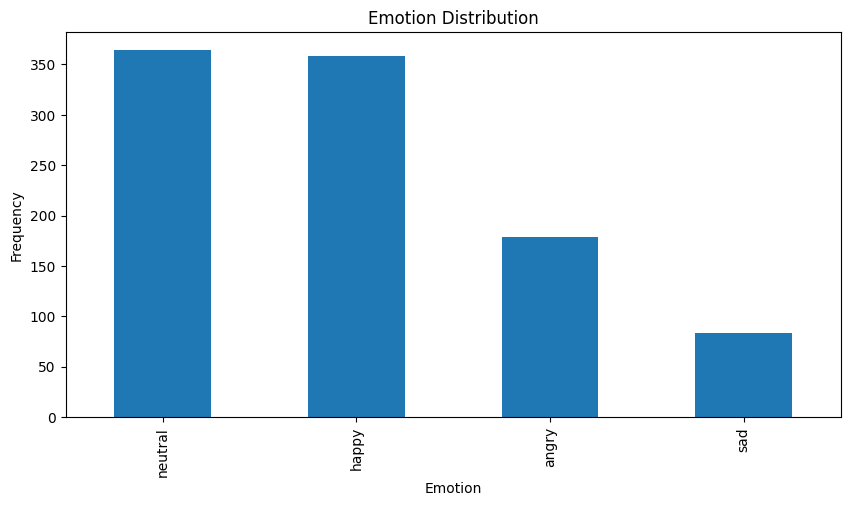

In [36]:
# plot the distribution of the target variable
labels = ['angry', 'happy', 'neutral', 'sad']
sorted_counts = data['emotion'].value_counts().reindex(labels).sort_values(ascending=False)

# Plot the sorted value counts
sorted_counts.plot(kind='bar', figsize=(10, 5), title='Emotion Distribution', xlabel="Emotion", ylabel="Frequency")

In [37]:
# Encoding the 'emotion' column
label_encoder = LabelEncoder()
data['emotion'] = label_encoder.fit_transform(data['emotion'])

# Split the dataset into train/validation/test sets (70/20/10 split)
labels = data['emotion']
features = data.drop('emotion', axis=1)

# Splitting the data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.1, random_state=42, stratify=labels)


# Feature Scaling for AUs
scaler = StandardScaler()
AU_columns = [col for col in data.columns if col.startswith('AU')]
scaler.fit(train_features)
train_features[AU_columns] = scaler.transform(train_features)
test_features[AU_columns] = scaler.transform(test_features)

In [38]:
# Grid search for SVM
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(train_features, train_labels)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, scoring='accuracy')

In [39]:
# Best parameters from Grid Search
best_params = grid_search.best_params_

# Create a new SVM model with the best parameters
final_model = grid_search.best_estimator_

# Train the model on the combined dataset
final_model.fit(train_features, train_labels)

print(f"Best Parameters: {best_params}")

results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('rank_test_score', inplace=True)
display(results[['params', 'mean_test_score', 'mean_train_score', 'rank_test_score']].head(10))

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


,params,mean_test_score,mean_train_score,rank_test_score
20,"{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}",0.827119,0.842938,1
16,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.827119,0.842938,1
28,"{'C': 100, 'gamma': 'auto', 'kernel': 'linear'}",0.822599,0.842938,3
24,"{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}",0.822599,0.842938,3
12,"{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}",0.819209,0.833333,5
8,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.819209,0.833333,5
0,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.814689,0.829379,7
4,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}",0.814689,0.829379,7
10,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.814689,0.847458,7
14,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.813559,0.848023,10


In [40]:
# Evaluate on the test set
train_accuracy = final_model.score(train_features, train_labels)
test_accuracy = final_model.score(test_features, test_labels)

print(f"Final Model Train Set Accuracy: {train_accuracy}")
print(f"Final Model Test Set Accuracy: {test_accuracy}")

Final Model Train Set Accuracy: 0.8293785310734463
Final Model Test Set Accuracy: 0.8181818181818182


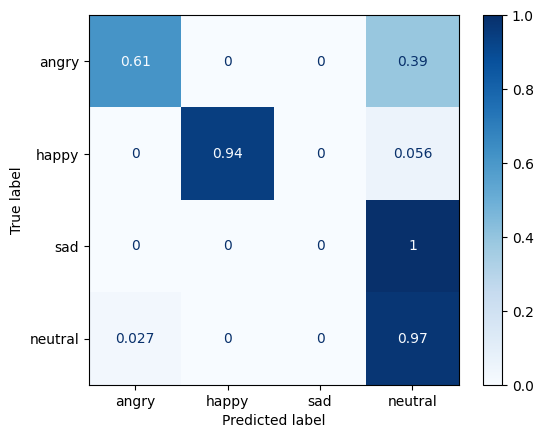

In [41]:
test_pred = final_model.predict(test_features)

labels = ["angry", "happy", "sad", "neutral"]
cm = confusion_matrix(label_encoder.inverse_transform(test_labels), label_encoder.inverse_transform(test_pred), normalize='true', labels=labels)
dsp = ConfusionMatrixDisplay(cm, display_labels=labels)
dsp.plot(cmap=plt.cm.Blues)
plt.show()

Kaggle Test Set Accuracy: 0.54070042593469


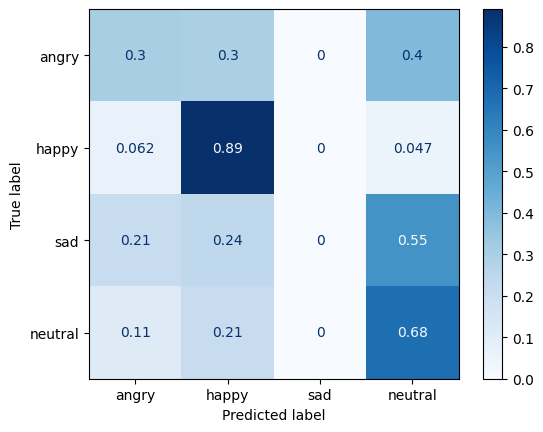

In [42]:
data_kaggle = pd.read_csv('aus_kaggle_set.csv')
data_kaggle_labels = label_encoder.transform(data_kaggle['emotion'])
data_kaggle_features = data_kaggle.drop('emotion', axis=1)

data_kaggle_features[AU_columns] = scaler.transform(data_kaggle_features)

kaggle_pred = final_model.predict(data_kaggle_features)

print(f"Kaggle Test Set Accuracy: {final_model.score(data_kaggle_features, data_kaggle_labels)}")

cm = confusion_matrix(label_encoder.inverse_transform(data_kaggle_labels), label_encoder.inverse_transform(kaggle_pred), normalize='true', labels=labels)
dsp = ConfusionMatrixDisplay(cm, display_labels=labels)
dsp.plot(cmap=plt.cm.Blues)
plt.show()

In [43]:
# Save the trained model to a file
with open('fer_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

# Optionally, you can also save the scaler and label encoder if you need them for preprocessing in the future
with open('fer_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open('fer_label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)


In [ ]:
# Load the model from the file
with open('fer_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Load the scaler and label encoder if needed
with open('fer_scaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)

with open('fer_label_encoder.pkl', 'rb') as file:
    loaded_label_encoder = pickle.load(file)


In [ ]:
detector = Detector()
path = "aaaaaaaa_6.png"
img = cv2.imread(path)

In [ ]:
detection = detector.detect_image(path)
detection.aus

In [ ]:
%%timeit
faces = detector.detect_faces(img)
landmarks = detector.detect_landmarks(img, detected_faces=faces)
new_au_data = detector.detect_aus(img, landmarks=landmarks)


In [ ]:
%%timeit
faces = detector.detect_faces(img)

In [ ]:
%%timeit
landmarks = detector.detect_landmarks(img, detected_faces=faces)

In [ ]:
%%timeit
new_au_data = detector.detect_aus(img, landmarks=landmarks)


In [ ]:
# Example: Assuming 'new_au_data' is your extracted AU features from Py-FEAT
new_au_data_scaled = loaded_scaler.transform(new_au_data)  # Use the same scaler as during training
predictions = loaded_model.predict(new_au_data_scaled)
predicted_emotions = loaded_label_encoder.inverse_transform(predictions)

predicted_emotions[0]